In [19]:
import matplotlib.pyplot as plt
import torch

MAX_EPOCHS = 10000

# Questions 1 - Understanding Gradient Descent and Momentum

### Part 1

In [20]:
# generate data
torch.manual_seed(45)
def generate_data(dataset=1, num_samples=40):
    if dataset == 1:
        x = torch.FloatTensor(num_samples).uniform_(-20, 20)
        y = 100 * x + 1 + torch.randn(num_samples)
    else:
        x = torch.FloatTensor(num_samples).uniform_(-1, 1)
        y = 3 * x + 4 + torch.randn(num_samples)
    return x, y

In [21]:
# Loss and gradient functions
def gradient(X, y, theta): return (1 / len(y)) * (X.T @ (X @ theta - y))
def loss(X, y, theta): return torch.mean((X @ theta - y)**2) / 2

In [22]:
# Plotting functions
def plot_loss(losses_gd, losses_sgd, dataset, alpha):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plotting loss vs. steps
    ax.plot(losses_gd, label=f'GD Loss (α={alpha})', color='blue', linewidth=2)
    ax.plot(losses_sgd, label=f'SGD Loss (α={alpha})', color='red', alpha=0.7)
    
    ax.set_yscale('log')
    # ax.set_xscale('log')
    # --- KEY CHANGE: Updated X-axis label ---
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (log scale)')
    ax.set_title(f'Loss vs. Epochs for Dataset {dataset}')
    ax.legend()
    ax.grid(True, which="both", ls="--")
    
    plt.tight_layout()
    plt.show()

import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_contours(X, y, path_gd, path_sgd, theta_star, dataset_num):
    # 1. Prepare data for plotting
    path_gd, path_sgd, theta_star = [p.squeeze().cpu().numpy() for p in (path_gd, path_sgd, theta_star)]

    # 2. Vectorized contour grid and loss calculation
    all_thetas = np.vstack([path_gd, path_sgd, theta_star])
    w0_range = np.linspace(all_thetas[:, 0].min() - 1, all_thetas[:, 0].max() + 1, 100)
    w1_range = np.linspace(all_thetas[:, 1].min() - 1, all_thetas[:, 1].max() + 1, 100)
    w0_grid, w1_grid = np.meshgrid(w0_range, w1_range)
    
    thetas_flat = torch.tensor(np.c_[w0_grid.ravel(), w1_grid.ravel()], dtype=torch.float32)
    loss_grid = torch.mean((X @ thetas_flat.T - y)**2, axis=0).reshape(w0_grid.shape)

    # 3. Plotting
    fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)
    max_epochs = max(len(path_gd), len(path_sgd))
    epoch_indices = np.unique(np.linspace(0, max_epochs - 1, 16).astype(int))

    for i, ax in enumerate(axes.flatten()):
        if i >= len(epoch_indices):
            ax.axis('off'); continue
        
        epoch_idx = epoch_indices[i]
        ax.contourf(w0_grid, w1_grid, loss_grid.cpu().numpy(), levels=20, cmap='viridis')
        ax.plot(theta_star[0], theta_star[1], 'r*', markersize=12)
        ax.plot(path_gd[:epoch_idx+1, 0], path_gd[:epoch_idx+1, 1], 'o-', c='deepskyblue', label='GD')
        ax.plot(path_sgd[:epoch_idx+1, 0], path_sgd[:epoch_idx+1, 1], '.-', c='tomato', label='SGD')
        ax.set_title(f'Epoch {epoch_idx}'); ax.grid(True)

    axes.flatten()[0].legend()
    fig.suptitle(f'Optimization Snapshots for Dataset {dataset_num}', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [23]:
# Gradient descent implementations
def gd(X, y, theta_star, alpha=0.01, max_epochs=MAX_EPOCHS, eps = 0.001, beta = 0): # beta = 0 means no momentum so vanilla gd
    theta = torch.zeros(X.shape[1], 1)
    velocity = torch.zeros_like(theta)
    steps = 0; path = []; losses = [] # to store the path of theta and loss ; values
    losses.append(loss(X, y, theta))
    path.append(theta)
    for epoch in range(max_epochs):
        steps += 1
        velocity = beta * velocity + (1 - beta) * gradient(X, y, theta)
        theta = theta - alpha * velocity
        # theta = theta - alpha*gradient(X, y, theta) # Vanilla GD update
        path.append(theta)
        losses.append(loss(X, y, theta))
        if torch.norm(theta - theta_star) < eps:
            return theta, torch.stack(path), torch.tensor(losses), steps
    
    return theta, torch.stack(path), torch.tensor(losses), steps

def sgd(X, y, theta_star, alpha=0.01, max_epochs=MAX_EPOCHS, eps=0.001, beta = 0): # beta = 0 means no momentum so vanilla sgd
    theta = torch.zeros(X.shape[1], 1)
    velocity = torch.zeros_like(theta)
    steps = 0; path = []; losses = []
    path.append(theta)
    losses.append(loss(X, y, theta))
    for epoch in range(max_epochs):
        # Generate a random permutation of indices
        indices = torch.randperm(len(y))
        
        for i in indices:
            steps += 1
            xi = X[i].reshape(1, -1)   # 2D
            yi = y[i].reshape(1, 1)    # 2D for consistency
            velocity = beta * velocity + (1 - beta) * (xi.T @ (xi @ theta - yi))
            theta = theta - alpha * velocity
            # theta = theta - alpha * (xi.T @ (xi @ theta - yi)) # Vanilla SGD update
            if torch.norm(theta - theta_star) < eps:
                losses.append(loss(X, y, theta))
                path.append(theta)
                return theta, torch.stack(path), torch.tensor(losses), steps
        path.append(theta)
        losses.append(loss(X, y, theta))
    return theta, torch.stack(path), torch.tensor(losses), steps


Dataset 1
Theta * =>  tensor([[ 1.2000],
        [99.9986]])
GD converged in 7159.0 steps. Estimated theta: tensor([[ 1.1990],
        [99.9985]])
SGD converged in 5968.7 steps. Estimated theta: tensor([[ 1.2006],
        [99.9987]])



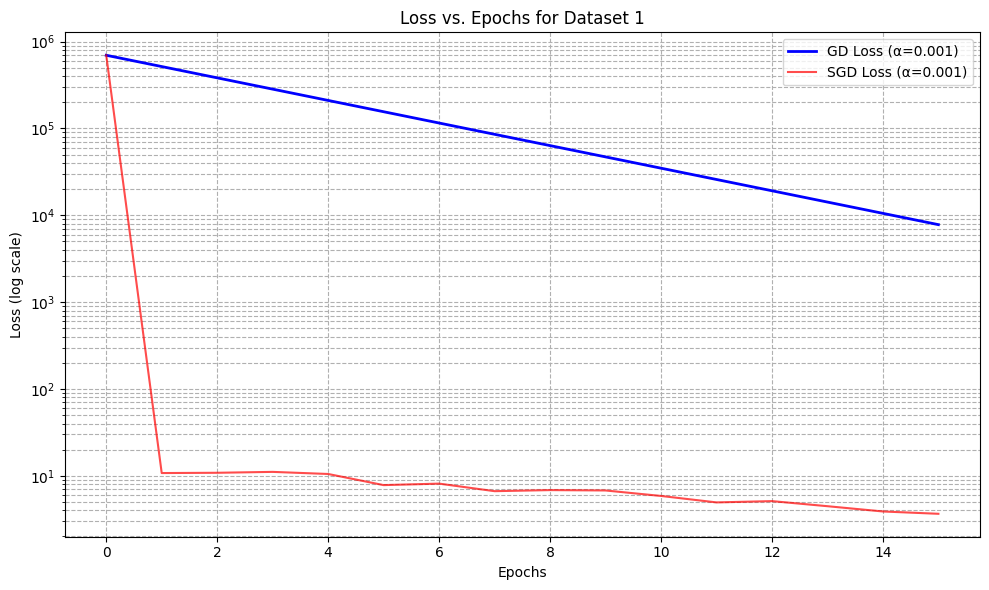

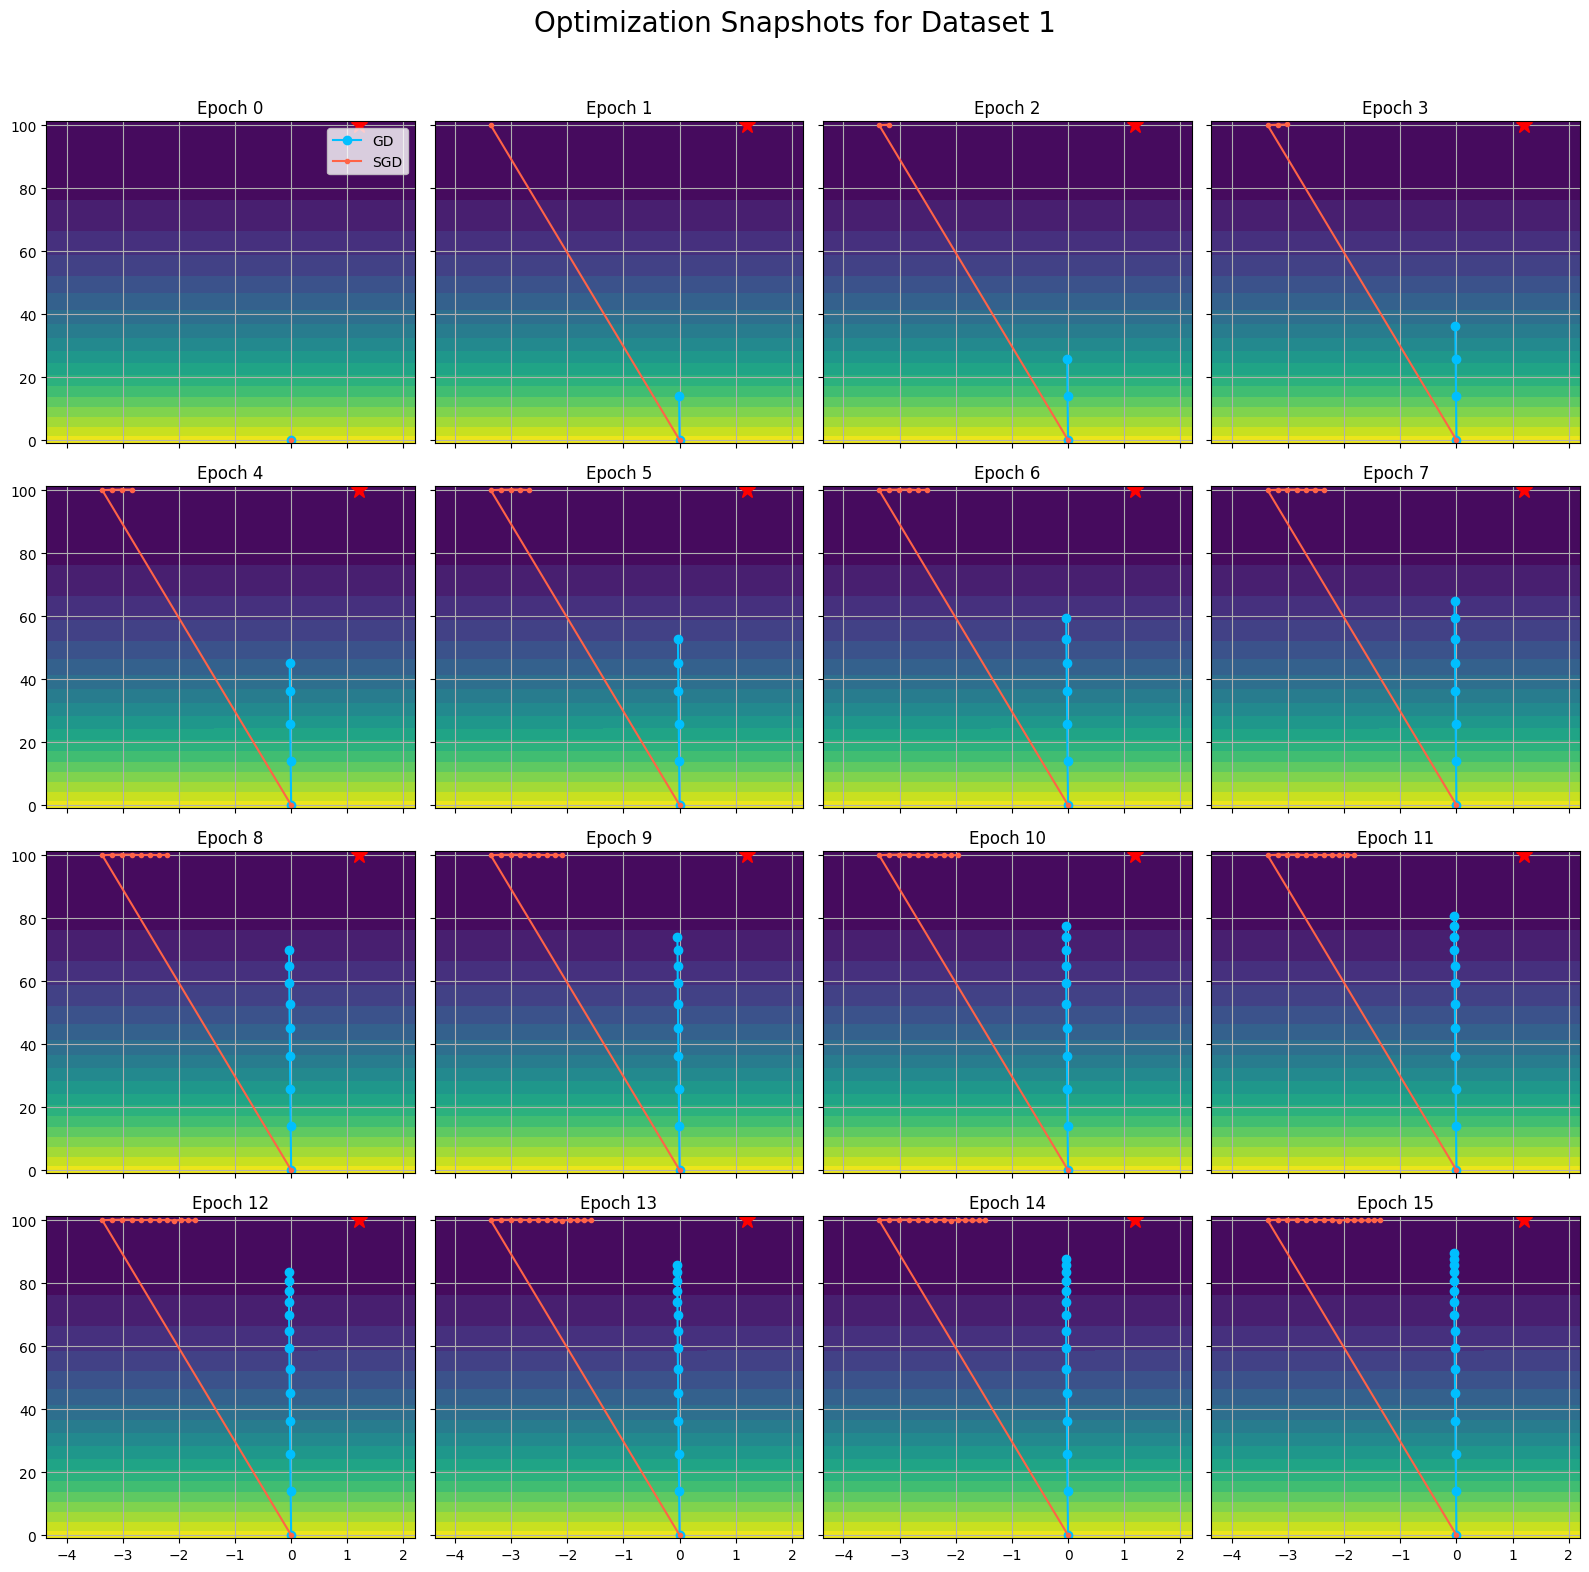


Dataset 2
Theta * =>  tensor([[4.0314],
        [3.4249]])
GD converged in 3356.0 steps. Estimated theta: tensor([[4.0312],
        [3.4239]])
SGD converged in 2723.1 steps. Estimated theta: tensor([[4.0314],
        [3.4251]])



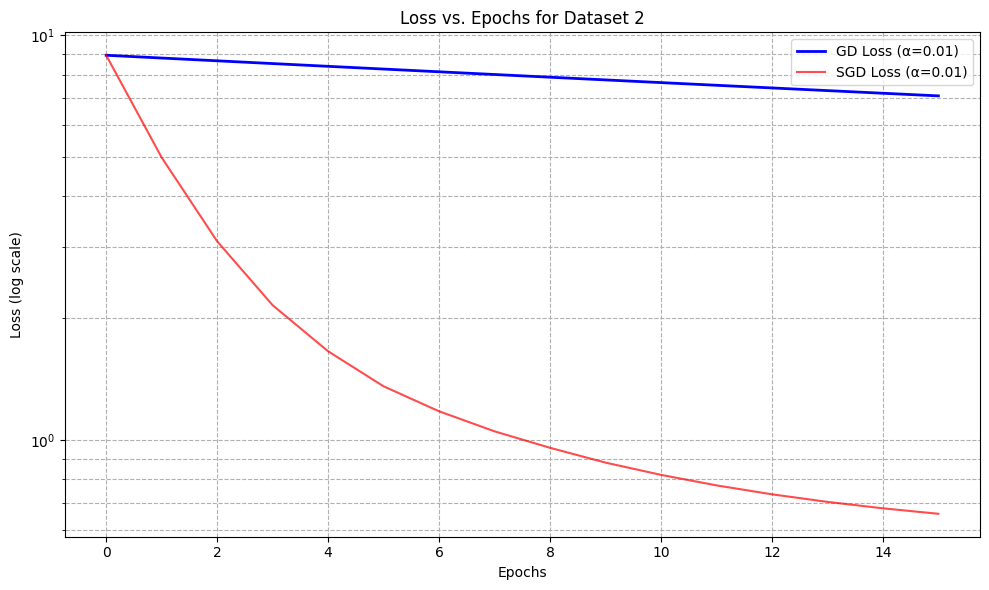

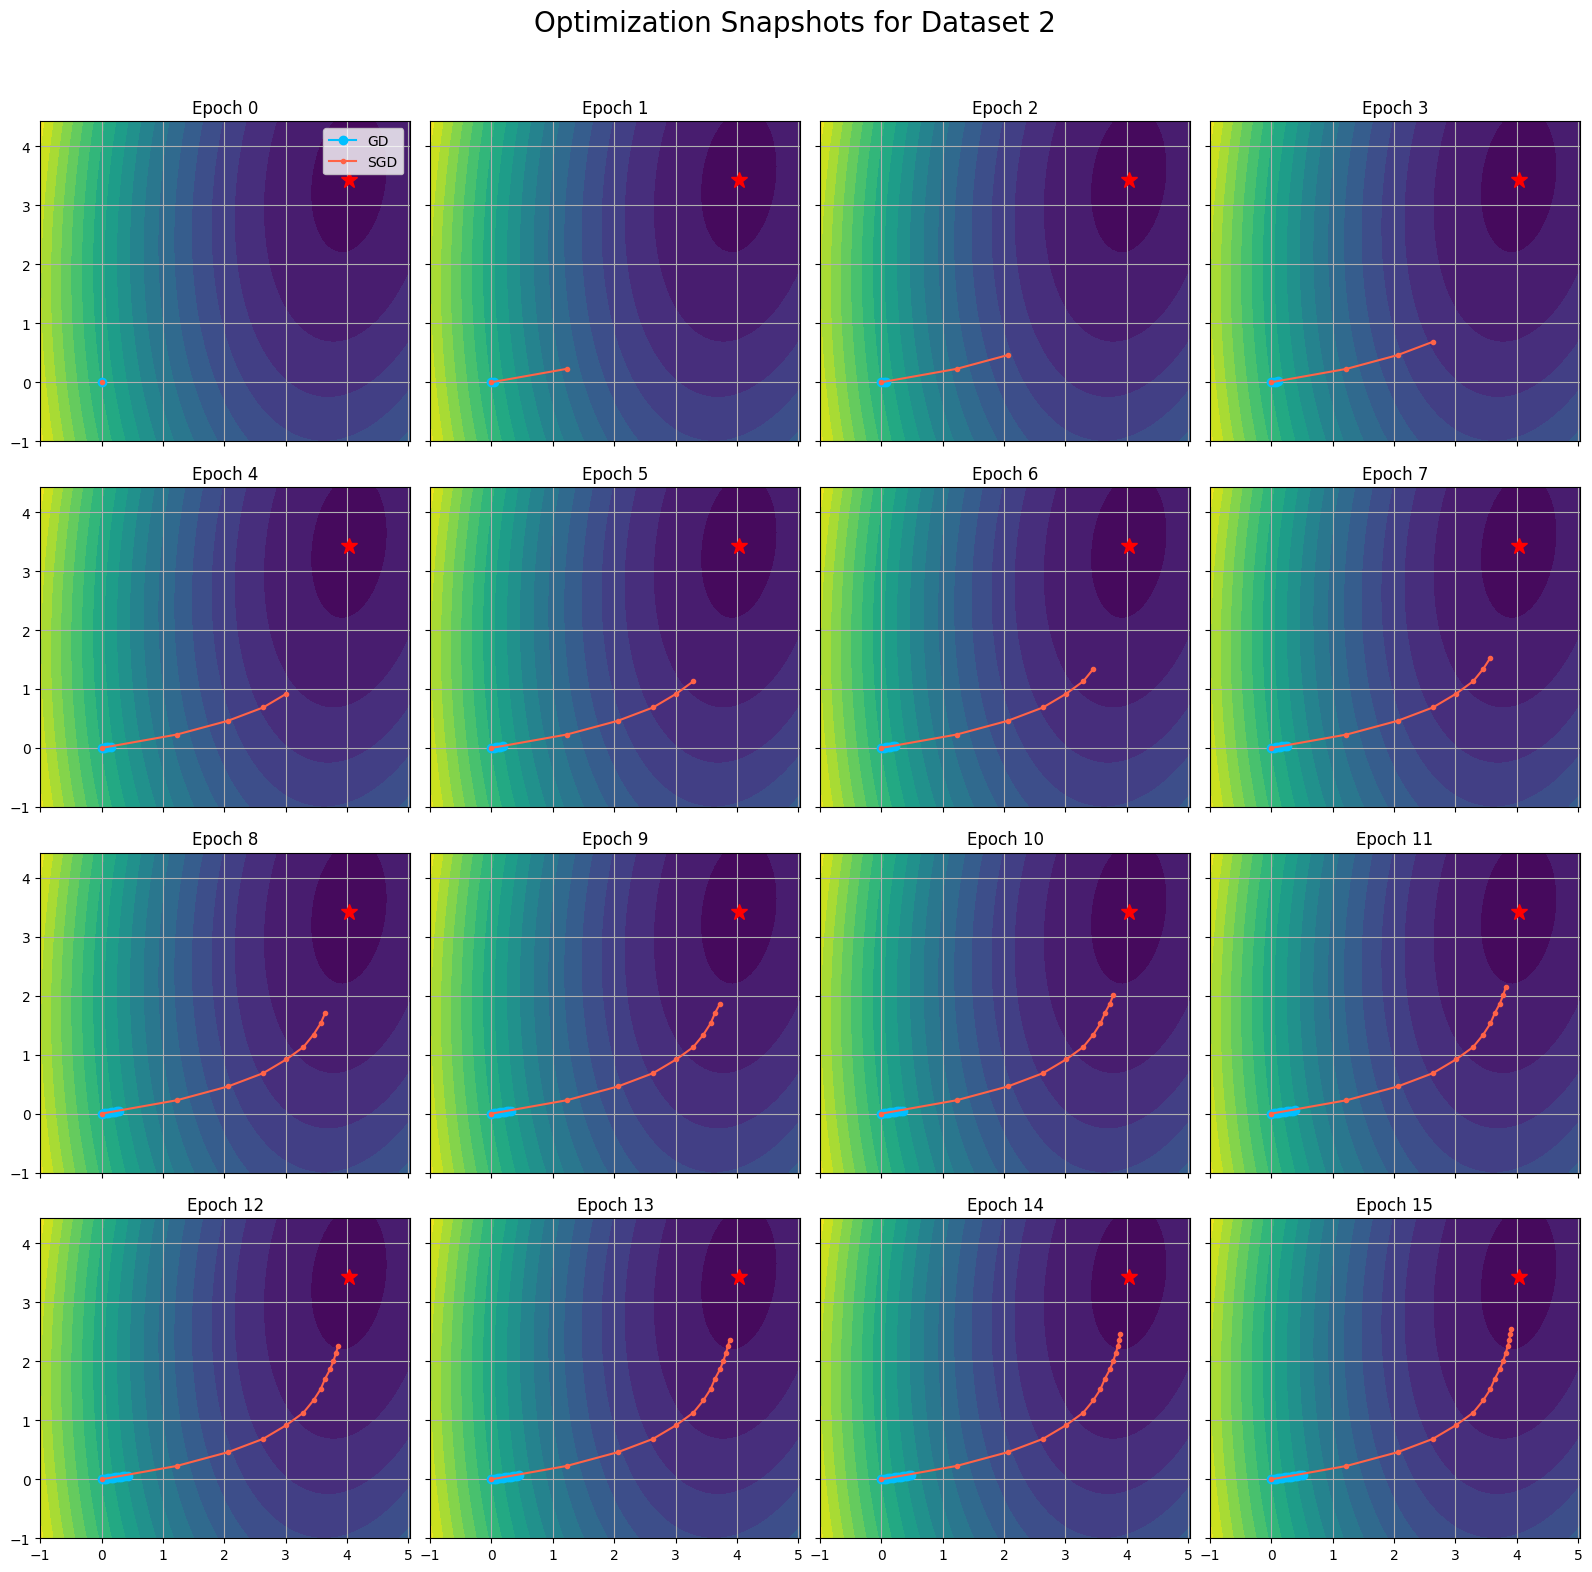

In [24]:
# ----- Run for Dataset 1 and 2 -----
for dataset in [1, 2]:
    print(f"\nDataset {dataset}")
    X, y = generate_data(dataset)
    if (len(X.shape) == 1): X = torch.vstack((torch.ones(len(X)), X)).T # Add intercept term
    if (len(y.shape) == 1): y = y.reshape((len(y), 1)) # Add intercept term

    theta_star = (X.T@X).inverse()@(X.T@y) # Optimal theta using Normal Equation
    print("Theta * => ", theta_star)

    avg_gd = 0; avg_sgd = 0; num_iter = 10; alpha = 0.001 if dataset == 1 else 0.01;
    theta_gd, path_gd, losses_gd, steps_gd, theta_sgd, path_sgd, losses_sgd, steps_sgd = None, None, None, None, None, None, None, None
    for i in range(num_iter):
        theta_gd, path_gd, losses_gd, steps_gd = gd(X, y, theta_star, alpha); avg_gd += steps_gd
        theta_sgd, path_sgd, losses_sgd, steps_sgd = sgd(X, y, theta_star, alpha); avg_sgd += steps_sgd
    avg_gd /= num_iter; avg_sgd /= num_iter
    print(f"GD converged in {avg_gd} steps. Estimated theta: {theta_gd}")
    print(f"SGD converged in {avg_sgd} steps. Estimated theta: {theta_sgd}\n")
    
    theta_gd, path_gd, losses_gd, steps_gd = gd(X, y, theta_star, alpha, 15);
    theta_sgd, path_sgd, losses_sgd, steps_sgd = sgd(X, y, theta_star, alpha, 15);
    plot_loss(losses_gd, losses_sgd, dataset, alpha)
    plot_contours(X, y, path_gd, path_sgd, theta_star, dataset)

##### So 

### Part 2


Dataset 1
Theta * =>  tensor([[  0.9672],
        [100.0001]])
GD converged in 9758.0 steps. Estimated theta: tensor([[  0.9682],
        [100.0000]])
SGD converged in 8907.2 steps. Estimated theta: tensor([[  0.9669],
        [100.0002]])



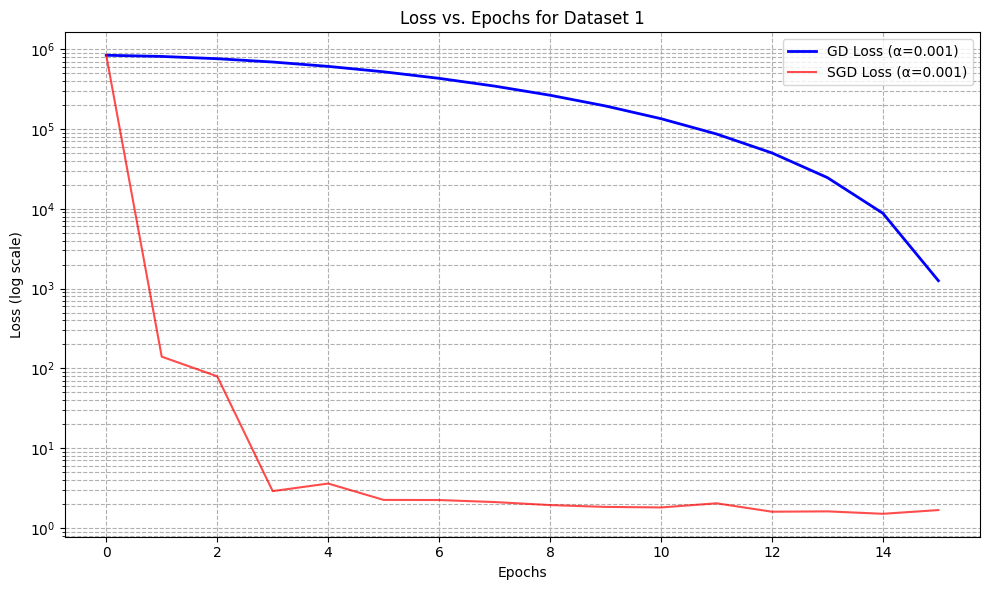

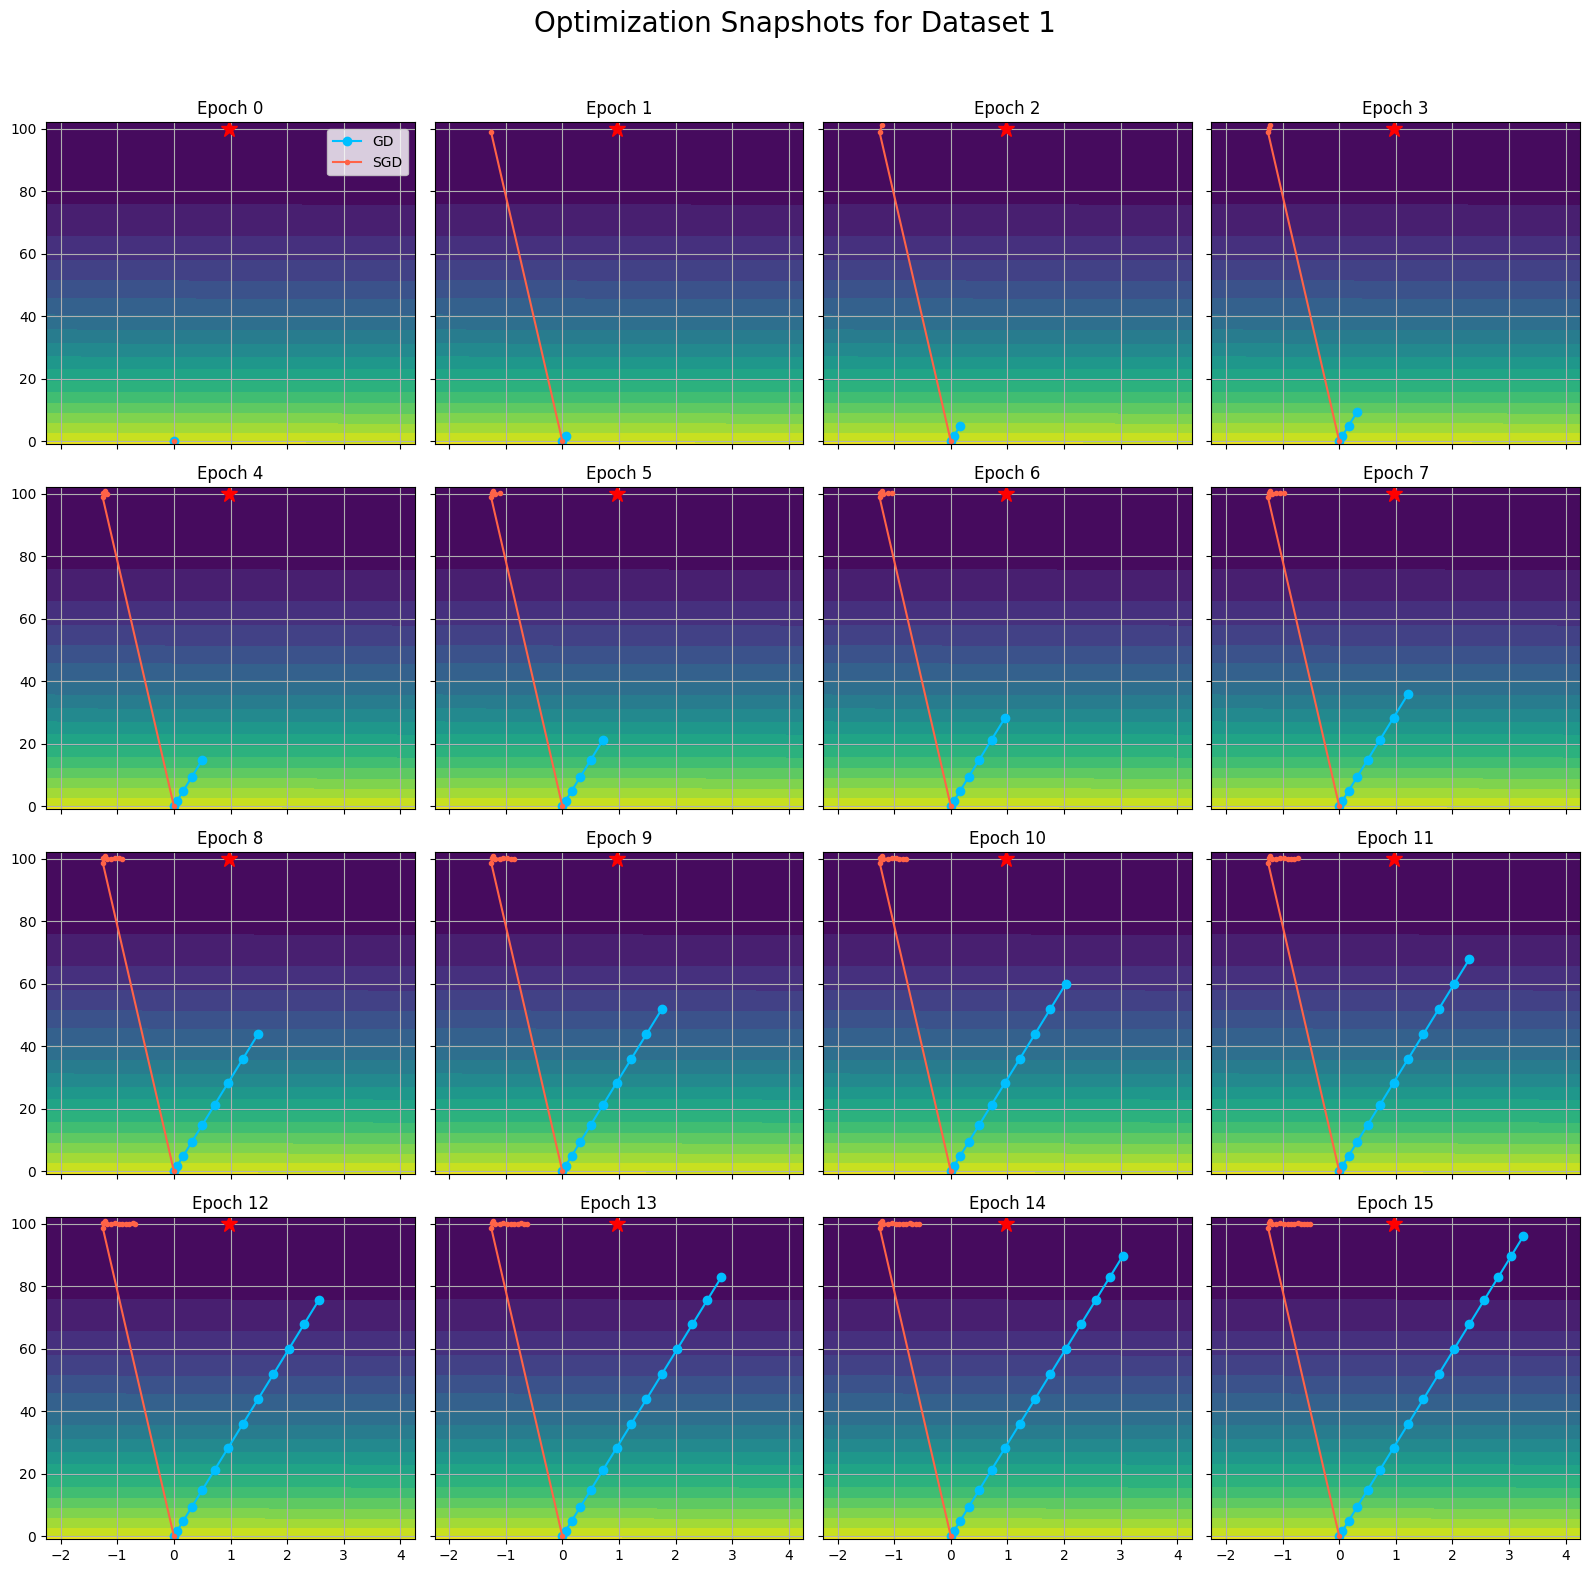


Dataset 2
Theta * =>  tensor([[4.1152],
        [3.5606]])
GD converged in 1991.0 steps. Estimated theta: tensor([[4.1152],
        [3.5596]])
SGD converged in 2072.4 steps. Estimated theta: tensor([[4.1151],
        [3.5607]])



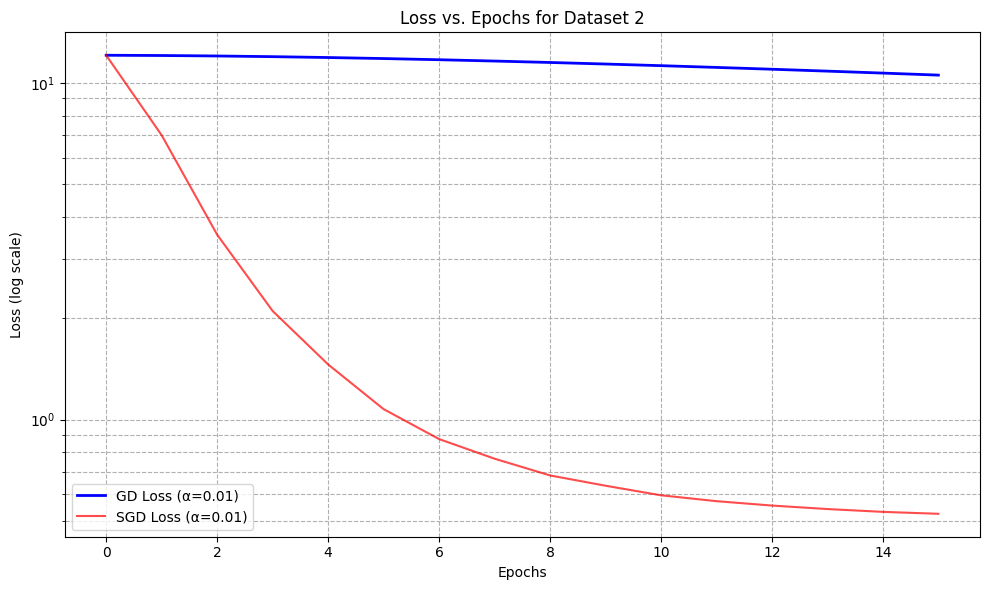

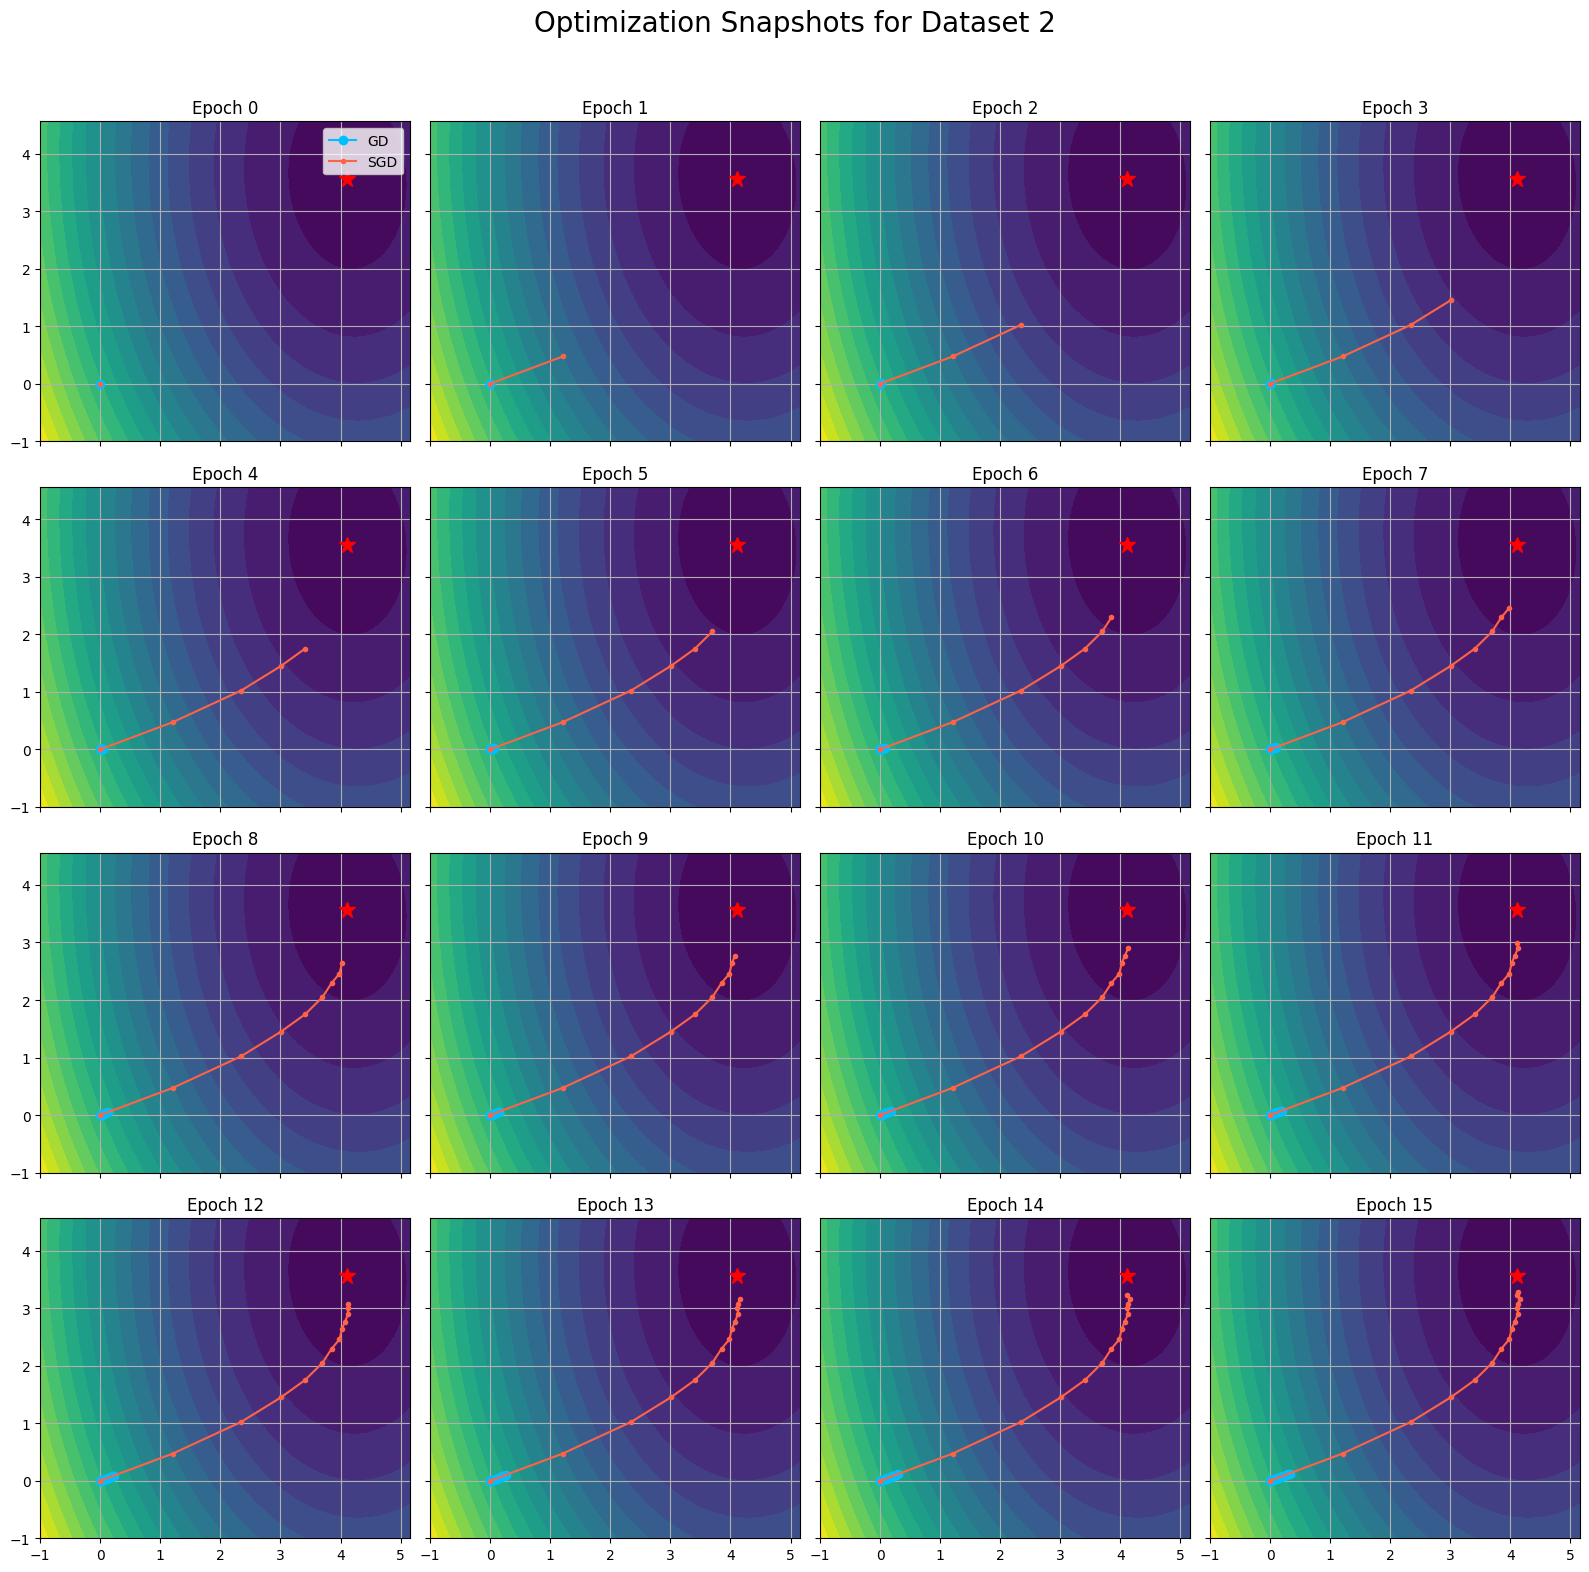

In [25]:
# Set momentum as 0.9 and run again
# ----- Run for Dataset 1 and 2 -----
for dataset in [1, 2]:
    print(f"\nDataset {dataset}")
    X, y = generate_data(dataset)
    if (len(X.shape) == 1): X = torch.vstack((torch.ones(len(X)), X)).T # Add intercept term
    if (len(y.shape) == 1): y = y.reshape((len(y), 1)) # Add intercept term

    theta_star = (X.T@X).inverse()@(X.T@y) # Optimal theta using Normal Equation
    print("Theta * => ", theta_star)

    avg_gd = 0; avg_sgd = 0; num_iter = 10; alpha = 0.001 if dataset == 1 else 0.01;
    theta_gd, path_gd, losses_gd, steps_gd, theta_sgd, path_sgd, losses_sgd, steps_sgd = None, None, None, None, None, None, None, None
    for i in range(num_iter):
        theta_gd, path_gd, losses_gd, steps_gd = gd(X, y, theta_star, alpha, beta=0.90); avg_gd += steps_gd
        theta_sgd, path_sgd, losses_sgd, steps_sgd = sgd(X, y, theta_star, alpha, beta=0.90); avg_sgd += steps_sgd
    avg_gd /= num_iter; avg_sgd /= num_iter
    print(f"GD converged in {avg_gd} steps. Estimated theta: {theta_gd}")
    print(f"SGD converged in {avg_sgd} steps. Estimated theta: {theta_sgd}\n")
    
    theta_gd, path_gd, losses_gd, steps_gd = gd(X, y, theta_star, alpha, 15, beta=0.90);
    theta_sgd, path_sgd, losses_sgd, steps_sgd = sgd(X, y, theta_star, alpha, 15, beta=0.90);
    plot_loss(losses_gd, losses_sgd, dataset, alpha)
    plot_contours(X, y, path_gd, path_sgd, theta_star, dataset)

### Conclusion

In this experiment, we implemented and compared full-batch Gradient Descent (GD), Stochastic Gradient Descent (SGD), and Momentum-based Gradient Descent for linear regression on two synthetic datasets. The results showed that full-batch GD converged smoothly but required more iterations due to large-scale features, while SGD reached the neighborhood of the minimizer faster though with higher variance in updates. The addition of momentum significantly improved convergence stability and speed by introducing a velocity term that dampened oscillations and accelerated motion in consistent directions. Visualizations such as contour plots, loss curves, and optimization path GIFs illustrated the distinct behaviors of each method, confirming that momentum-based GD provides the best balance between convergence speed and smoothness. Overall, GD offered stability, SGD offered efficiency for larger datasets, and momentum GD combined both advantages effectively.